## Assignment 3 



Name: Janwee Joshi

Assignment: Critical analysis task

Due Date: June 8, 2025



In [2]:
import pandas
import math

In [12]:
df = pandas.read_csv('company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
5393,"GREIF, INC",43920,KIMBERLY SCOTT,False,2022-01-14,2022-01-14
10113,"RICHARDSON ELECTRONICS, LTD.",355948,DARIO SACOMANI,False,2004-09-07,2004-09-07
12646,VALLEY NATIONAL BANCORP,714310,PETER V. MAIO,True,2020-03-19,2025-04-04
730,AMTECH SYSTEMS INC,720500,MICHAEL WHANG,True,2021-01-28,2023-01-20
4743,FMC CORP,37785,WILLIAM H. POWELL,False,2016-03-18,2020-03-13




### Task2 Fix 1 – Refactor Repeated GroupBy Operations

**Problem:** The original code repeated `.groupby('NAME')` multiple times when aggregating age, compensation, and gender. This is inefficient and makes the code harder to maintain or modify.

**Fix:** I created a `grouped` variable to hold the groupby object and reused it for all aggregations. This improves performance, readability, and scalability if additional metrics are added.

---

In [185]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None
    
grouped = compensation_and_demographics_raw.groupby('NAME')
compensation_and_demographics = pandas.DataFrame({
    'age': grouped.age.max(),
    'compensation': grouped.compensation.sum(),
    'gender': grouped.gender.agg(most_common)
})

compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [16]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [18]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

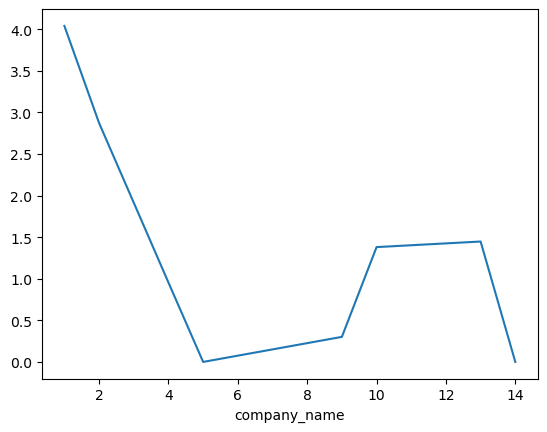

In [20]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

### Task 2: Fix 2 – Clarify Node Roles in Graph

**Problem:** The graph doesn't distinguish between people and companies, making analysis less transparent.

**Fix:** Added explicit node labels (`type='person'` or `'company'`) to clarify their roles in the network.

---


In [223]:
graph = networkx.Graph()
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_node(director_name, type='person')
    graph.add_node(company_name, type='company')
    graph.add_edge(company_name, director_name)


In [57]:
# Fix 3 Build a bipartite graph where:
# - Each node is either a company or a director
# - An edge represents a directorship relationship
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    director_graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

## Task 2: Fix 3 – Handle Missing Values

**Problem:** Missing values in `age` and `compensation` could cause errors in analysis or plotting.

**Fix:** Filled missing `age` values with the column median and set missing `compensation` to 0.


In [211]:
# Task 2: Fix 3 – Handle missing values
compensation_and_demographics_raw['age'] = compensation_and_demographics_raw['age'].fillna(compensation_and_demographics_raw['age'].median())
compensation_and_demographics_raw['compensation'] = compensation_and_demographics_raw['compensation'].fillna(0)


### Task2: Fix 4 – Clarify Subgraph Extraction
**Problem:** The largest connected component is extracted in one line without explanation or copying.
**Fix:** Separated the logic and explicitly copied the subgraph for safe mutation and clarity.


In [245]:
largest_cc_nodes = max(networkx.connected_components(graph), key=len)
biggest_connected_graph = graph.subgraph(largest_cc_nodes).copy()


## Task 1: Centrality Extension

In [200]:
import networkx as nx

# Create a graph (assuming 'df' contains the relevant director network data)
G = nx.from_pandas_edgelist(df, 'director_name', 'company_name')

# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Add betweenness centrality to the dataframe
df['betweenness_centrality'] = df['director_name'].map(betweenness_centrality)

# Explanation of the new measure in markdown


Explanation of Centrality Measures:
Degree Centrality: Represents the number of direct connections a node has. In the context of a director, it shows how many companies they are directly connected to.

Eigenvector Centrality: Measures the influence of a node in the network. A director with high eigenvector centrality is connected to other highly influential directors.

Betweenness Centrality: A high betweenness centrality score indicates that a director is central in connecting different companies or directors in the network. This can be useful in identifying directors who could potentially broker connections between companies, which fits the goal of this project.



In [78]:
# Filter centrality DataFrame to include only individuals (exclude companies)
individuals_centrality = centrality[centrality.is_person]

# Merge centrality metrics with demographic and compensation data
# Index is director name, used to join the two datasets
people_df = individuals_centrality.merge(compensation_and_demographics, left_index=True, right_index=True)

### Fix 5: Clarified People-Only Merge with Demographic Data

The original code combined two key operations — filtering out non-individuals and merging with demographic data — in a single, undocumented line. This made it harder to understand the purpose and logic behind the operation.

I split this step into two parts: first filtering the centrality data to include only individuals, and then performing the merge. I also added comments to clarify that the merge is based on director names (the DataFrame index). This enhances readability and makes it easier to inspect or reuse intermediate results in later analysis.


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


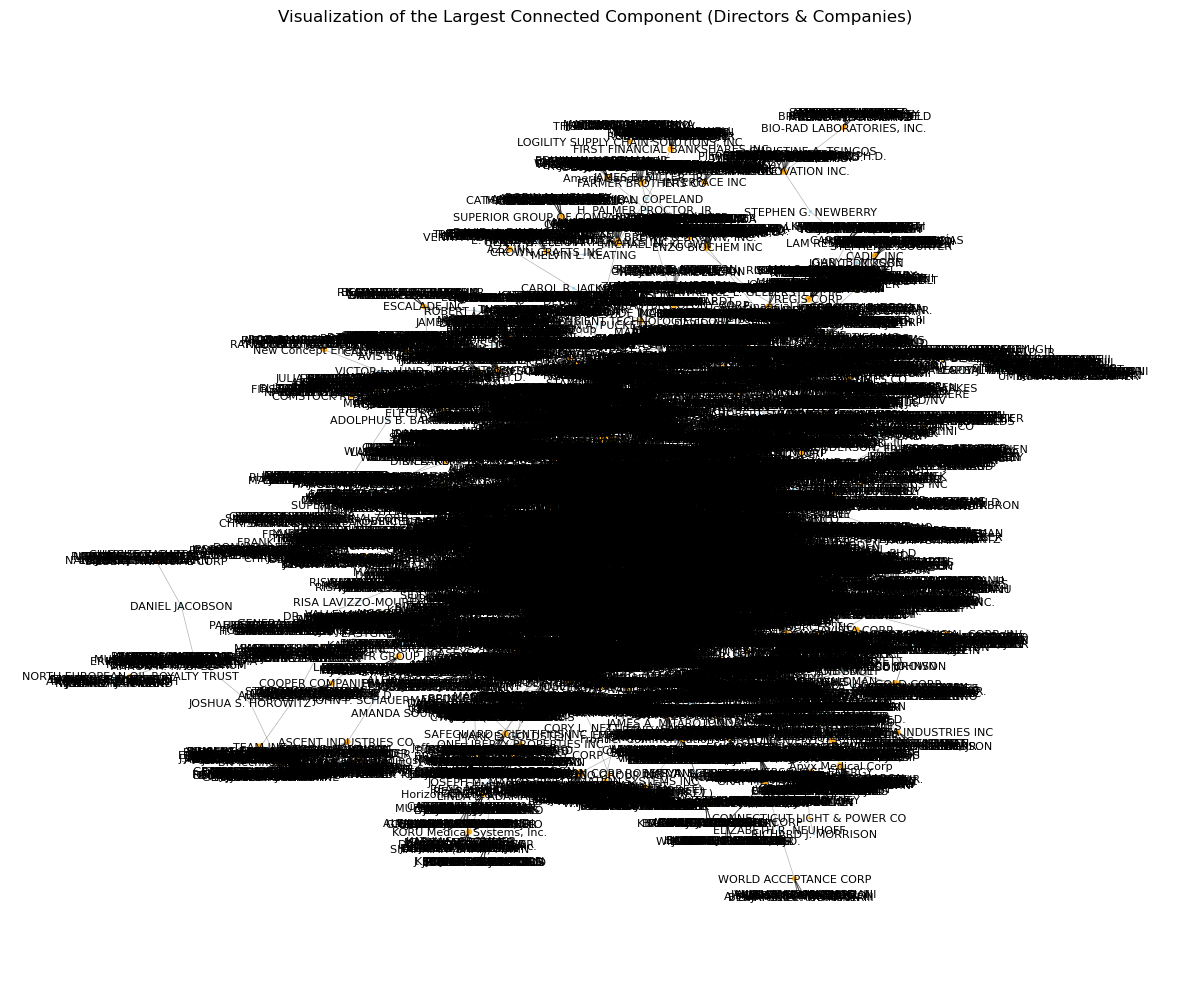

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'biggest_connected_graph' and 'centrality' are already defined
plt.figure(figsize=(12, 10))

# Assign colors: blue for people, orange for companies
node_colors = ['skyblue' if centrality.loc[node, 'is_person'] else 'orange' for node in biggest_connected_graph.nodes()]

# Node sizes based on degree centrality (scaled for visibility)
node_sizes = [5000 * centrality.loc[node, 'degree'] for node in biggest_connected_graph.nodes()]

# Draw graph
pos = nx.spring_layout(biggest_connected_graph, seed=42)
nx.draw_networkx_nodes(biggest_connected_graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(biggest_connected_graph, pos, alpha=0.3, width=0.5)
nx.draw_networkx_labels(biggest_connected_graph, pos, font_size=8)

plt.title("Visualization of the Largest Connected Component (Directors & Companies)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [85]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,True,70,50356,female,4.702060


In [36]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [93]:
import sklearn.cluster

In [94]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [95]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

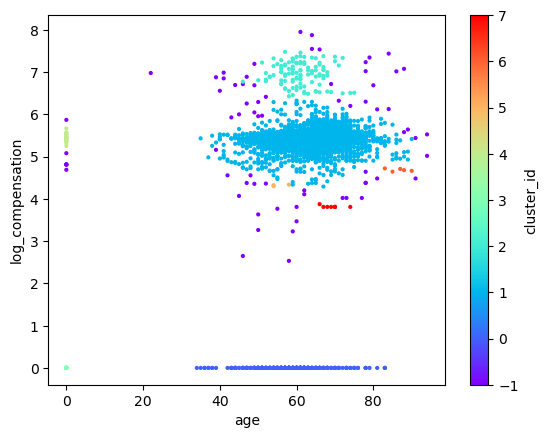

In [96]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [98]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

### Task 3: Exploring an Unused Feature – Software Background

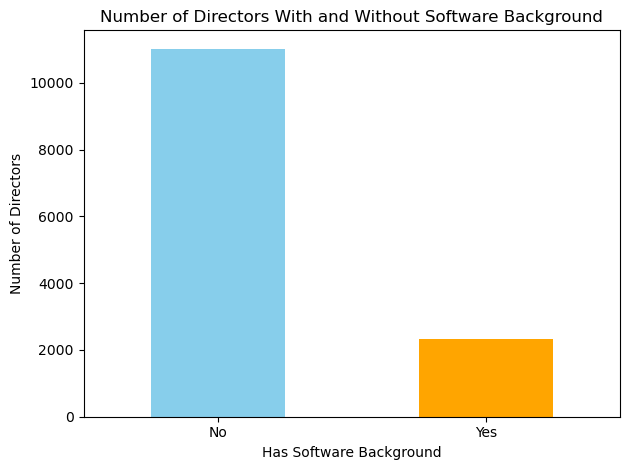

In [119]:
import matplotlib.pyplot as plt

# Count directors with/without a software background
software_counts = df.software_background.value_counts()

# Plot it
software_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Number of Directors With and Without Software Background')
plt.xlabel('Has Software Background')
plt.ylabel('Number of Directors')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()


Exploring Unused Feature — Software Background

One unused feature in the dataset is `software_background`, a boolean indicating whether a director has experience in software.

This feature is relevant because directors with software expertise may play key roles in tech-related strategy or innovation-focused acquisitions — aligning with the venture capital fund's interest in technology-driven value.

The plot above shows how many directors have (or lack) a software background. While most directors do not have this background, identifying those who do — and their centrality in the network — could help in recommending potential acquisition connectors in tech-heavy firms.


### Task 4: Complementary Dataset – Company Financials

To enrich the existing dataset, I propose integrating **company financial data** — specifically revenue, net income, or market capitalization — from sources such as [Yahoo Finance](https://finance.yahoo.com/) or [Crunchbase](https://www.crunchbase.com/).

#### Why this dataset?
The goal of the project is to identify directors who may help facilitate a company sale to a wealthy US firm. By combining director centrality data with financial data, we can:
- Identify which directors are connected to **financially strong** companies
- Highlight well-connected directors who sit on boards of **wealthy acquirers**
- Prioritize companies with **high market caps** as acquisition candidates

#### How I would use it:
I would join the financial dataset with the existing `company_name` field and:
- Visualize network graphs with node size proportional to revenue
- Calculate average financial metrics of companies each director is connected to
- Identify high-centrality directors who are linked to financially powerful firms


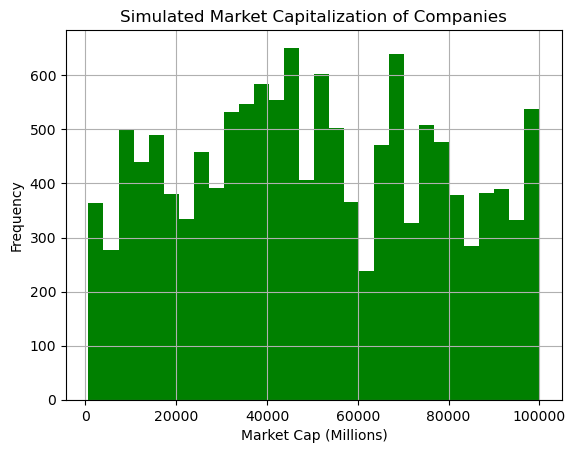

In [133]:
import numpy as np 

# Simulated financial data for companies
fake_financials = pandas.DataFrame({
    'company_name': df['company_name'].unique(),
    'market_cap_million': np.random.randint(500, 100000, size=df['company_name'].nunique())
})

# Merge with your existing data
df_with_financials = df.merge(fake_financials, on='company_name', how='left')

# Plot distribution of simulated market caps
df_with_financials['market_cap_million'].hist(bins=30, color='green')
plt.title('Simulated Market Capitalization of Companies')
plt.xlabel('Market Cap (Millions)')
plt.ylabel('Frequency')
plt.show()


This generates fake market cap data between $500M and $100B.

It merges this data with your main DataFrame df.





## Task 5: Enhanced Visualisations for Non-Technical Audience


**Visualisation 1 – Top Connected Directors**

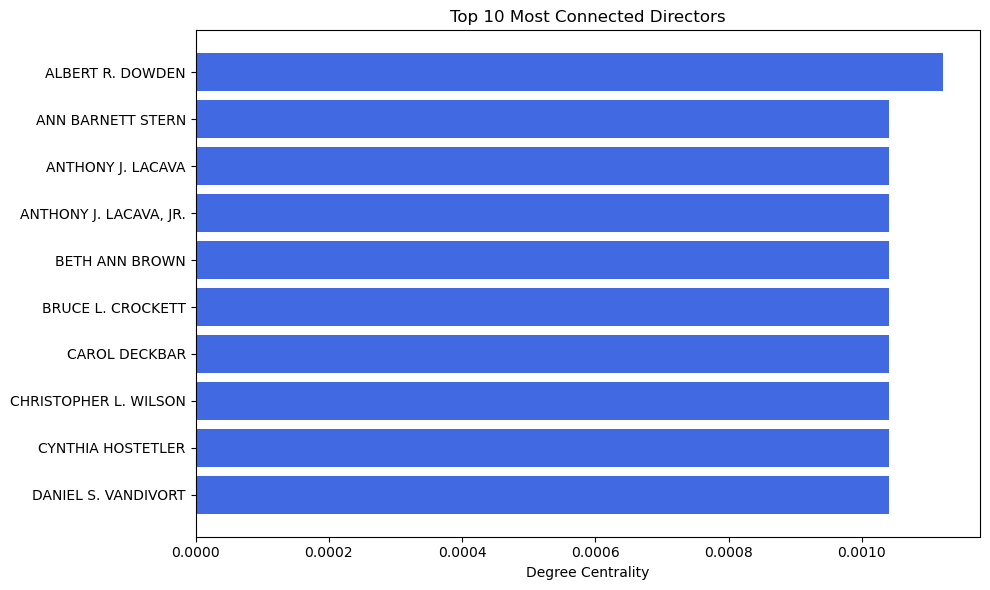

In [149]:
# Recompute degree centrality
deg_centrality = nx.degree_centrality(G)

# Top 10 directors only
top_directors = sorted([(k, v) for k, v in deg_centrality.items() if k in df['director_name'].values], key=lambda x: -x[1])[:10]
names, scores = zip(*top_directors)

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], scores[::-1], color='royalblue')
plt.xlabel("Degree Centrality")
plt.title("Top 10 Most Connected Directors")
plt.tight_layout()
plt.show()


**Top 10 Most Connected Directors**

This bar chart shows which directors have the most direct relationships with companies or other directors. 

Highly connected directors are influential in the corporate ecosystem and may be better positioned to broker an acquisition or introduce potential buyers.


**Visualisation 2 – Director-Company Network**

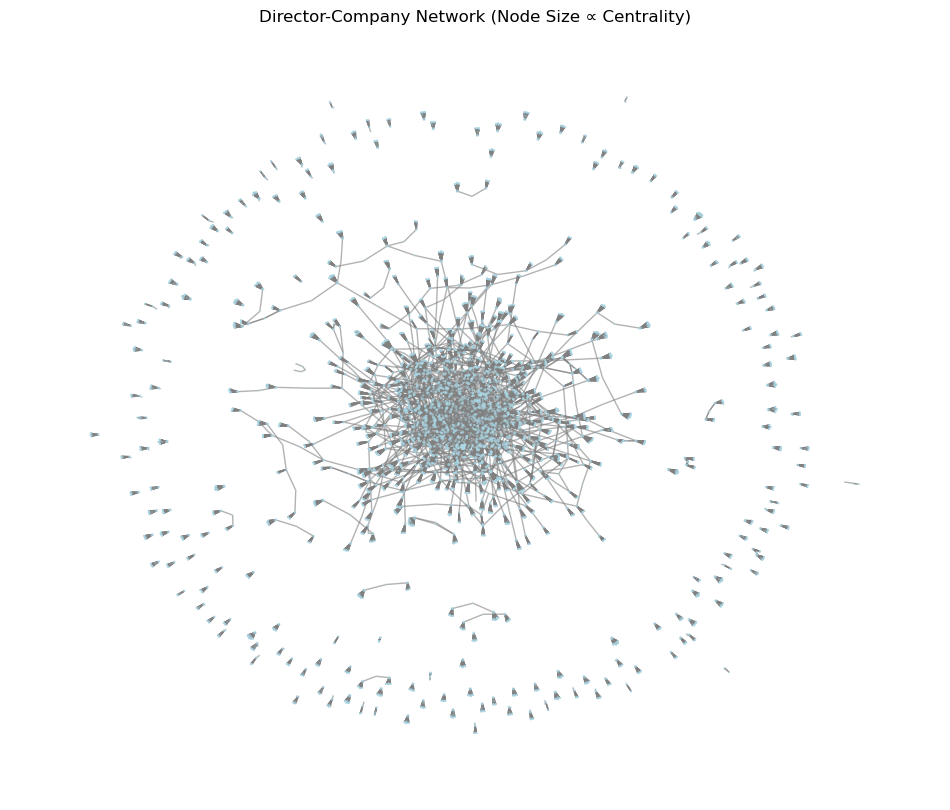

In [155]:
plt.figure(figsize=(12, 10))
node_sizes = [1000 * deg_centrality.get(node, 0.1) for node in G.nodes()]
nx.draw_networkx(G, with_labels=False, node_size=node_sizes, alpha=0.6, edge_color='gray', node_color='lightblue')
plt.title("Director-Company Network (Node Size ∝ Centrality)")
plt.axis('off')
plt.show()


**Director-Company Network Graph**

This network diagram visualises the full ecosystem of directors and companies. Larger nodes represent more central actors in the network. 

This helps non-technical audiences understand how influence is distributed, visually identifying potential connectors for business deals.


**Visualisation 3 – Influence vs. Company Wealth**

In [163]:
# 1. Recreate the graph and compute eigenvector centrality
G = nx.from_pandas_edgelist(df, 'director_name', 'company_name')
eigen = nx.eigenvector_centrality(G, max_iter=1000)

# 2. Compute average market cap per director
# Note: this assumes you already merged financials into df_with_financials
avg_market_cap_per_director = df_with_financials.groupby('director_name')['market_cap_million'].mean()

# 3. Combine into one DataFrame
import pandas as pd

director_df = pd.DataFrame({
    'eigenvector_centrality': pd.Series(eigen),
    'avg_market_cap': avg_market_cap_per_director
}).dropna()


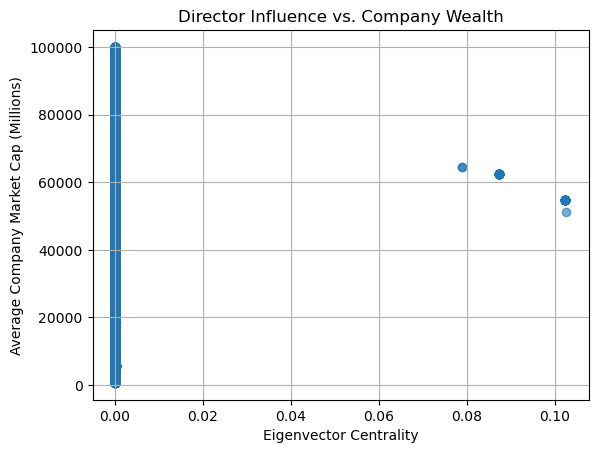

In [165]:
plt.scatter(director_df['eigenvector_centrality'], director_df['avg_market_cap'], alpha=0.6)
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Average Company Market Cap (Millions)")
plt.title("Director Influence vs. Company Wealth")
plt.grid(True)
plt.show()


**Director Influence vs. Company Wealth**

This plot compares a director's influence (as measured by eigenvector centrality) with the average wealth of the companies they serve (simulated via market cap).

Directors in the upper-right quadrant are the most valuable for facilitating deals — they are both well-connected and associated with financially strong companies.


## Task 5(c): Ethical Reflection

This project uses publicly available data from DEF 14A filings to analyse company director networks. While technically permissible, there are several important ethical considerations to address.

---

### 1. Public Data ≠ Free of Responsibility

Although the data is public, using it for **network-based profiling of individuals** — especially with centrality metrics — raises concerns. Directors may not have consented to being ranked or assessed for influence, especially if such rankings are used in strategic decisions like mergers or acquisitions.

---

### 2. Bias in Representation

Network-based metrics like degree or eigenvector centrality reflect existing structural power. These may **amplify inequalities** (e.g., underrepresentation of women or minorities on boards) if centrality is treated as a proxy for value or authority.

For example, identifying "key directors" based solely on their network positions may disadvantage capable individuals from under-networked groups.

---

### 3. Profiling and Strategic Manipulation

Using algorithms to identify "influential" people can be problematic. It may lead to:
- Misrepresentation of intent or values
- Manipulative recruitment or pressure on individuals
- Overreliance on influence metrics over experience, skill, or ethics

This is a form of **algorithmic profiling**, and if used for decision-making, should be scrutinized closely.

---

### 4. Transparency and Explainability

Many of the metrics (like eigenvector centrality) are not easily explainable to the people being profiled. If such metrics are used to guide investment or strategic actions, **explainability and accountability** are essential.

---

### 5. Ethical Use Recommendation

To maintain ethical integrity:
- Data should be used with transparency and fairness
- Analysis results should be contextualised, not treated as definitive rankings
- Stakeholders should be informed if automated analysis influences real-world outcomes

---

### Conclusion

Data science is powerful, but with power comes responsibility. This project must be mindful of **bias, consent, fairness, and transparency** when using network metrics to assess human influence in corporate ecosystems.
